### Imports

In [90]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [91]:
def word_freq(dataframe):
    # get all words appearing in reliable articles
    reliable_words = [word for list in list(itertools.chain(dataframe.loc[dataframe['type'] == 'reliable'].content)) for word in list]
    # get all words appearing in fake articles
    fake_words = [word for list in list(itertools.chain(dataframe.loc[dataframe['type'] == 'fake'].content)) for word in list]
    # count words in both lists
    count_reliable = Counter(reliable_words)
    count_fake = Counter(fake_words)
    return pd.DataFrame({'reliable': pd.Series(count_reliable), 'fake': pd.Series(count_fake)})

### Loading the dataset

In [92]:
import pandas as pd
import regex as re
from cleantext import clean
data = pd.read_csv("data/sample_preprocessed_ver_2023-03-23-1679583810.csv", index_col=0)

In [93]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)
data['content'] = data['content'].apply(string_to_list)

In [94]:
len(data)

3087

### Simple Model - Logistic Regression

In [95]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x299b4a830>,
                max_features=200000)

In [97]:
X_train.shape

(2469,)

In [98]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaker', ..., 'zynga', 'zypern', 'zyuganov'],
      dtype=object)

In [99]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [100]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [101]:
pred = logreg.predict(X_val)

In [102]:
accuracy_score(y_val, pred)

0.7378640776699029

In [103]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7272727272727273

[[120  34]
 [ 47 108]]


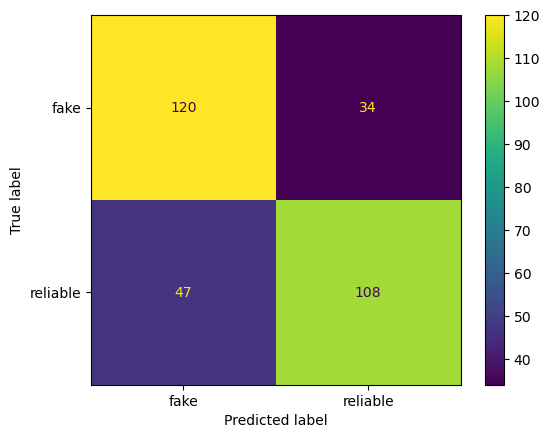

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()



### Advanced Model - Naive Bayes

In [105]:
def to_bigrams(words):
    return list(nltk.bigrams(words))

In [106]:
chunck_size = 10000
data_chunks = [data[i:i+chunck_size] for i in range(0, data.shape[0], chunck_size)]

In [107]:
for chunck in data_chunks:
    chunck['content'] = chunck['content'].apply(to_bigrams)

In [108]:
data = pd.concat(data_chunks)

In [110]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=10000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x29dbda440>, max_features=10000)

In [112]:
X_train.shape

(2469,)

In [113]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [114]:
vectorizer.get_feature_names_out()

array([['abc', 'news'],
       ['abdul', 'majid'],
       ['abigail', 'marguli'],
       ...,
       ['zero', 'hedg'],
       ['zika', 'viru'],
       ['zombi', 'apocalyps']], dtype=object)

In [115]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [116]:
pred = nb.predict(X_val)

In [117]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.7799352750809061

In [118]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7605633802816901

[[133  21]
 [ 47 108]]


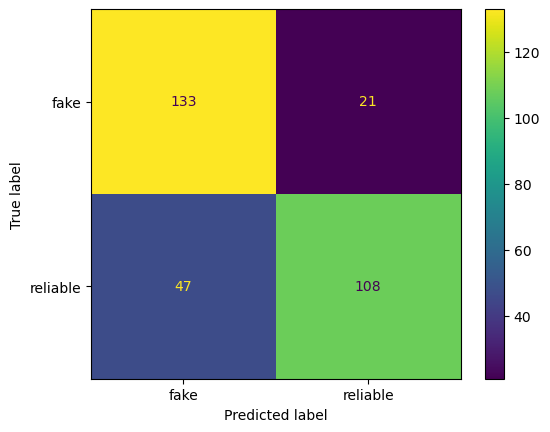

In [119]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()